# Store Sales

## Problem Statement

Corporación Favorita, an Ecuadorian grocery retailer, faces challenges in accurately forecasting unit sales across its stores, leading to overstocking or understocking and resulting in increased food waste and decreased customer satisfaction. To address this, we will develop a machine learning model to predict daily unit sales at less than 0.5 RMSE by average. Utilizing historical sales data, store metadata, promotional information, oil prices, and holiday events, we aim to deliver a robust forecasting model within 4 weeks.

## Imports and utility functions

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
warnings.filterwarnings('ignore')
def time_series_plot_by_category(category, showLegend = True, logSales = False):
    category_sales = sales_df.groupby(['date_month', category])['sales'].sum().reset_index()
    category_sales['log_sales'] = np.log(category_sales['sales'])
    
    plt.figure(figsize=(9, 6))
    if logSales:
        sns.lineplot(data=category_sales, x='date_month', y='log_sales', hue=category)
        plt.title(f'Sales (log) by {category.capitalize()}')
        plt.ylabel('Sales (log)')
    else:
        sns.lineplot(data=category_sales, x='date_month', y='sales', hue=category)
        plt.title(f'Sales by {category.capitalize()}')
        plt.ylabel('Sales')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    if showLegend:
        plt.legend(title=category.capitalize())
    else:
        plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()    

## Data Wrangling 

### Import data

In [4]:
train = pd.read_csv('data/train.csv')
transactions = pd.read_csv('data/transactions.csv')
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv')
holidays = pd.read_csv('data/holidays_events.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [10]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

### Basic statistics

In [12]:
train.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [13]:
transactions.describe()

,date,store_nbr,transactions
count,83488,83488.000000,83488.000000
mean,2015-05-20 16:07:40.866232064,26.939237,1694.602158
min,2013-01-01 00:00:00,1.000000,5.000000
25%,2014-03-27 00:00:00,13.000000,1046.000000
50%,2015-06-08 00:00:00,27.000000,1393.000000
75%,2016-07-14 06:00:00,40.000000,2079.000000
max,2017-08-15 00:00:00,54.000000,8359.000000
std,NaN,15.608204,963.286644


In [14]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [15]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

### Unify information

In [16]:
train = train.merge(transactions, on=['date', 'store_nbr'], how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holidays, on='date', how='left')
train = train.merge(stores, on='store_nbr', how='left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13


In [17]:
train = train.rename(columns={'dcoilwtico': 'daily_oil_price', 'type_x': 'holiday_type', 'locale': 'holiday_locale', 'description': 'holiday_description', 'transferred': 'holiday_transferred', 'type_y': 'store_type', 'cluster': 'store_cluster'})
train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,daily_oil_price,holiday_type,holiday_locale,locale_name,holiday_description,holiday_transferred,city,state,store_type,store_cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13


In [18]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   3054348 non-null  int64         
 1   date                 3054348 non-null  datetime64[ns]
 2   store_nbr            3054348 non-null  int64         
 3   family               3054348 non-null  object        
 4   sales                3054348 non-null  float64       
 5   onpromotion          3054348 non-null  int64         
 6   transactions         2805231 non-null  float64       
 7   daily_oil_price      2099196 non-null  float64       
 8   holiday_type         502524 non-null   object        
 9   holiday_locale       502524 non-null   object        
 10  locale_name          502524 non-null   object        
 11  holiday_description  502524 non-null   object        
 12  holiday_transferred  502524 non-null   object        
 1

In [19]:
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test = test.merge(oil, on='date', how='left')
test = test.merge(holidays, on='date', how='left')
test = test.merge(stores, on='store_nbr', how='left')
test.head()

,id,date,store_nbr,family,onpromotion,transactions,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,46.8,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,NaN,46.8,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,NaN,46.8,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,46.8,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,NaN,46.8,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13


In [20]:
test = test.rename(columns={'dcoilwtico': 'daily_oil_price', 'type_x': 'holiday_type', 'locale': 'holiday_locale', 'description': 'holiday_description', 'transferred': 'holiday_transferred', 'type_y': 'store_type', 'cluster': 'store_cluster'})

In [21]:
test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   28512 non-null  int64         
 1   date                 28512 non-null  datetime64[ns]
 2   store_nbr            28512 non-null  int64         
 3   family               28512 non-null  object        
 4   onpromotion          28512 non-null  int64         
 5   transactions         0 non-null      float64       
 6   daily_oil_price      21384 non-null  float64       
 7   holiday_type         1782 non-null   object        
 8   holiday_locale       1782 non-null   object        
 9   locale_name          1782 non-null   object        
 10  holiday_description  1782 non-null   object        
 11  holiday_transferred  1782 non-null   object        
 12  city                 28512 non-null  object        
 13  state                28512 non-

### Handle missing values

In [22]:
train.isna().sum(), test.isna().sum()

(id                           0
 date                         0
 store_nbr                    0
 family                       0
 sales                        0
 onpromotion                  0
 transactions            249117
 daily_oil_price         955152
 holiday_type           2551824
 holiday_locale         2551824
 locale_name            2551824
 holiday_description    2551824
 holiday_transferred    2551824
 city                         0
 state                        0
 store_type                   0
 store_cluster                0
 dtype: int64,
 id                         0
 date                       0
 store_nbr                  0
 family                     0
 onpromotion                0
 transactions           28512
 daily_oil_price         7128
 holiday_type           26730
 holiday_locale         26730
 locale_name            26730
 holiday_description    26730
 holiday_transferred    26730
 city                       0
 state                      0
 store_type          

In [23]:
target_columns = ['holiday_type', 'holiday_locale', 'locale_name', 'holiday_description', 'holiday_transferred']

for col in target_columns:
    train[col].fillna('none', inplace=True)
    test[col].fillna('none', inplace=True)

In [24]:
train['daily_oil_price'].interpolate(method='linear', inplace=True)
train['daily_oil_price'].fillna(method='bfill', inplace=True)

test['daily_oil_price'].interpolate(method='linear', inplace=True)
test['daily_oil_price'].fillna(method='bfill', inplace=True)

In [25]:
train.isna().sum(), test.isna().sum()

(id                          0
 date                        0
 store_nbr                   0
 family                      0
 sales                       0
 onpromotion                 0
 transactions           249117
 daily_oil_price             0
 holiday_type                0
 holiday_locale              0
 locale_name                 0
 holiday_description         0
 holiday_transferred         0
 city                        0
 state                       0
 store_type                  0
 store_cluster               0
 dtype: int64,
 id                         0
 date                       0
 store_nbr                  0
 family                     0
 onpromotion                0
 transactions           28512
 daily_oil_price            0
 holiday_type               0
 holiday_locale             0
 locale_name                0
 holiday_description        0
 holiday_transferred        0
 city                       0
 state                      0
 store_type                 0
 store_c

For the test dataset, information on 'transactions' is not available. Therefore, these features must be omitted when building models. 

In [26]:
train = train.drop(columns=['transactions'])
test = test.drop(columns=['transactions'])
print(train.info(show_counts=True))
print(test.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   3054348 non-null  int64         
 1   date                 3054348 non-null  datetime64[ns]
 2   store_nbr            3054348 non-null  int64         
 3   family               3054348 non-null  object        
 4   sales                3054348 non-null  float64       
 5   onpromotion          3054348 non-null  int64         
 6   daily_oil_price      3054348 non-null  float64       
 7   holiday_type         3054348 non-null  object        
 8   holiday_locale       3054348 non-null  object        
 9   locale_name          3054348 non-null  object        
 10  holiday_description  3054348 non-null  object        
 11  holiday_transferred  3054348 non-null  object        
 12  city                 3054348 non-null  object        
 1

### Add features

In [27]:
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter

test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['quarter'] = test['date'].dt.quarter

In [28]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,daily_oil_price,holiday_type,holiday_locale,locale_name,holiday_description,holiday_transferred,city,state,store_type,store_cluster,day_of_week,month,quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1


In [29]:
test.head()

,id,date,store_nbr,family,onpromotion,daily_oil_price,holiday_type,holiday_locale,locale_name,holiday_description,holiday_transferred,city,state,store_type,store_cluster,day_of_week,month,quarter
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,none,none,none,none,none,Quito,Pichincha,D,13,2,8,3
1,3000889,2017-08-16,1,BABY CARE,0,46.8,none,none,none,none,none,Quito,Pichincha,D,13,2,8,3
2,3000890,2017-08-16,1,BEAUTY,2,46.8,none,none,none,none,none,Quito,Pichincha,D,13,2,8,3
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,none,none,none,none,none,Quito,Pichincha,D,13,2,8,3
4,3000892,2017-08-16,1,BOOKS,0,46.8,none,none,none,none,none,Quito,Pichincha,D,13,2,8,3


### Export processed train and test data

In [30]:
sales_df = train

In [31]:
train.to_csv('data/train_combined.csv')
test.to_csv('data/test_combined.csv')

### Adjust column data type for EDA

In [32]:
sales_df['date_month'] = sales_df['date'].dt.to_period('M').dt.to_timestamp()
sales_df['store_nbr'] = sales_df['store_nbr'].astype('category')
sales_df['store_cluster'] = sales_df['store_cluster'].astype('category')

In [33]:
daily_sales = sales_df.groupby('date')['sales'].sum().reset_index()
daily_sales.rename(columns={'sales': 'total_daily_sales'}, inplace=True)
daily_sales_by_store = sales_df.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()
daily_sales_by_store.rename(columns={'sales': 'total_daily_sales_by_store_nbr'}, inplace=True)

sales_df = sales_df.merge(daily_sales, on=['date'], how='left')
sales_df = sales_df.merge(daily_sales_by_store, on=['date', 'store_nbr'], how='left')

sales_df['contribution_ratio_by_date'] = sales_df['sales'] / daily_sales['total_daily_sales']
sales_df['contribution_ratio_by_date_store_nbr'] = sales_df['sales'] / daily_sales_by_store['total_daily_sales_by_store_nbr'] 
sales_df.head()

,id,date,store_nbr,family,sales,onpromotion,daily_oil_price,holiday_type,holiday_locale,locale_name,...,store_type,store_cluster,day_of_week,month,quarter,date_month,total_daily_sales,total_daily_sales_by_store_nbr,contribution_ratio_by_date,contribution_ratio_by_date_store_nbr
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,NaN


In [34]:
sales_df['contribution_ratio_by_date'] = sales_df['contribution_ratio_by_date'].fillna(0)
sales_df['contribution_ratio_by_date_store_nbr'] =  sales_df['contribution_ratio_by_date_store_nbr'].fillna(0)

In [35]:
sales_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 24 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   id                                    3054348 non-null  int64         
 1   date                                  3054348 non-null  datetime64[ns]
 2   store_nbr                             3054348 non-null  category      
 3   family                                3054348 non-null  object        
 4   sales                                 3054348 non-null  float64       
 5   onpromotion                           3054348 non-null  int64         
 6   daily_oil_price                       3054348 non-null  float64       
 7   holiday_type                          3054348 non-null  object        
 8   holiday_locale                        3054348 non-null  object        
 9   locale_name                           3054348 

## EDA

In [36]:
sales_df.head()

,id,date,store_nbr,family,sales,onpromotion,daily_oil_price,holiday_type,holiday_locale,locale_name,...,store_type,store_cluster,day_of_week,month,quarter,date_month,total_daily_sales,total_daily_sales_by_store_nbr,contribution_ratio_by_date,contribution_ratio_by_date_store_nbr
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0


In [37]:
daily_sales.head()

,date,total_daily_sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


### Sales patterns over time

#### Insights Summary

- Trend Analysis:
There is a consistent upward trend in sales from 2013 to 2017, suggesting robust business growth and successful market expansion.

- Seasonal Fluctuations:
Sales display pronounced seasonal patterns, with significant peaks during end of the years.

- Residuals:
Residuals indicate additional, unexplained factors influencing sales, pointing to the need for further investigation into potential external influences like local events or market changes.

- Statistical Findings (ANOVA and Tukey's HSD):
  - Weekday vs. Weekend: Sales on weekends(Saturdays and Sundays), are significantly higher than on weekdays, with Thursday experiencing notably lower sales.
  - Monthly Trends: December stands out with significantly higher sales compared to other months

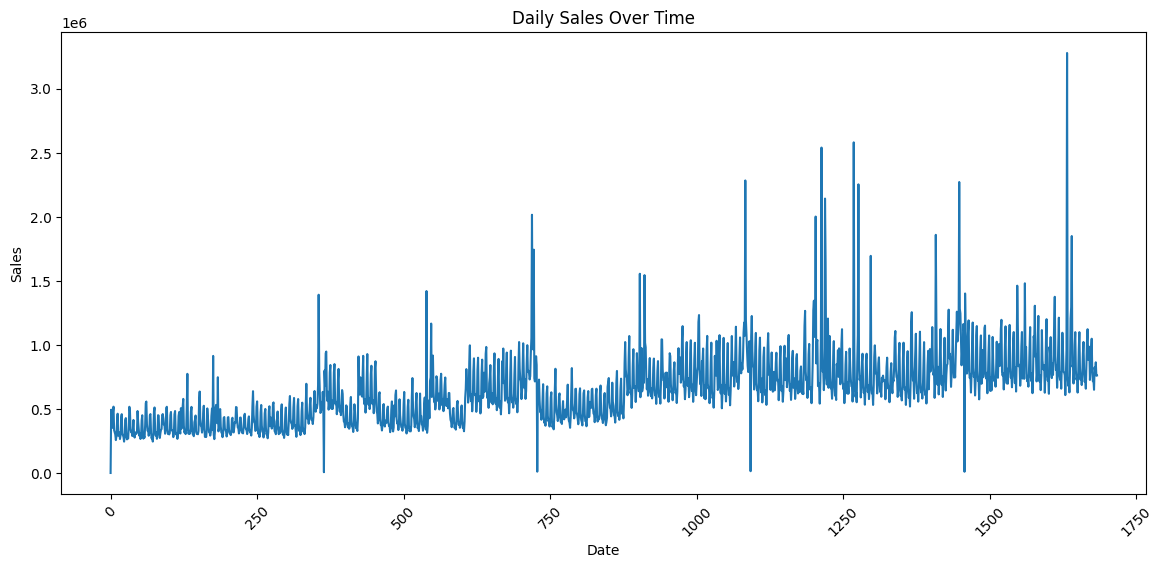

In [38]:
plt.figure(figsize=(14, 6))
#plt.plot(sales_df['date'], sales_df['sales'])
plt.plot(daily_sales['total_daily_sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [39]:
monthly_sales = daily_sales.resample('M', on='date').sum()
monthly_sales.head()

,total_daily_sales
date,
2013-01-31,1.032762e+07
2013-02-28,9.658960e+06
2013-03-31,1.142850e+07
2013-04-30,1.099346e+07
2013-05-31,1.198556e+07


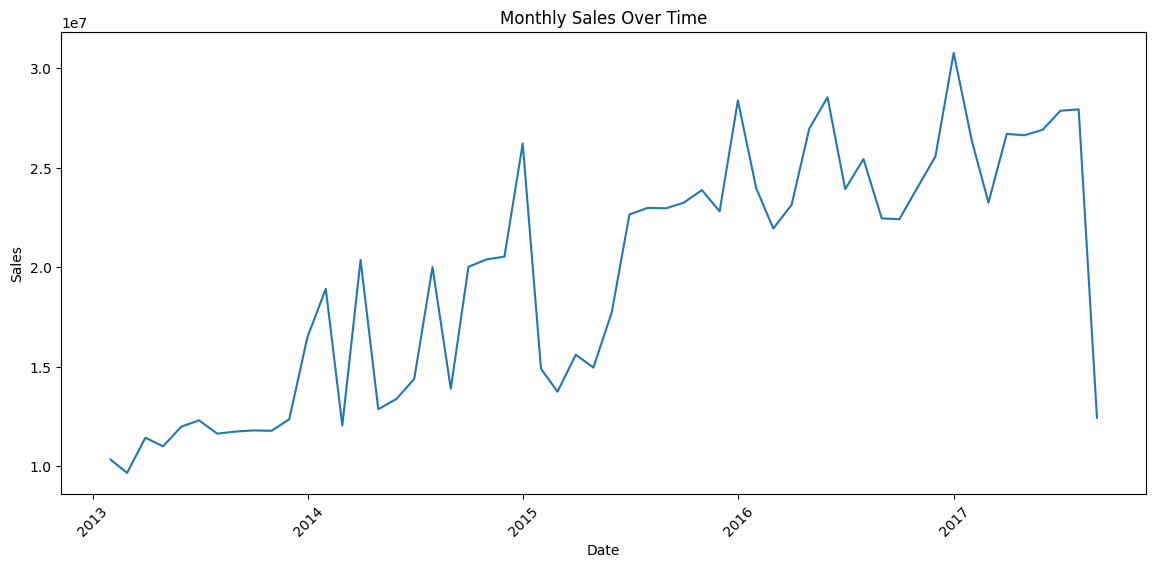

In [40]:
# Monthly Aggregation of Sales
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['total_daily_sales'])
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [41]:
quater_sales = daily_sales.resample('Q', on='date').sum()
quater_sales.head()

,total_daily_sales
date,
2013-03-31,3.141508e+07
2013-06-30,3.527861e+07
2013-09-30,3.516267e+07
2013-12-31,4.063159e+07
2014-03-31,5.131558e+07


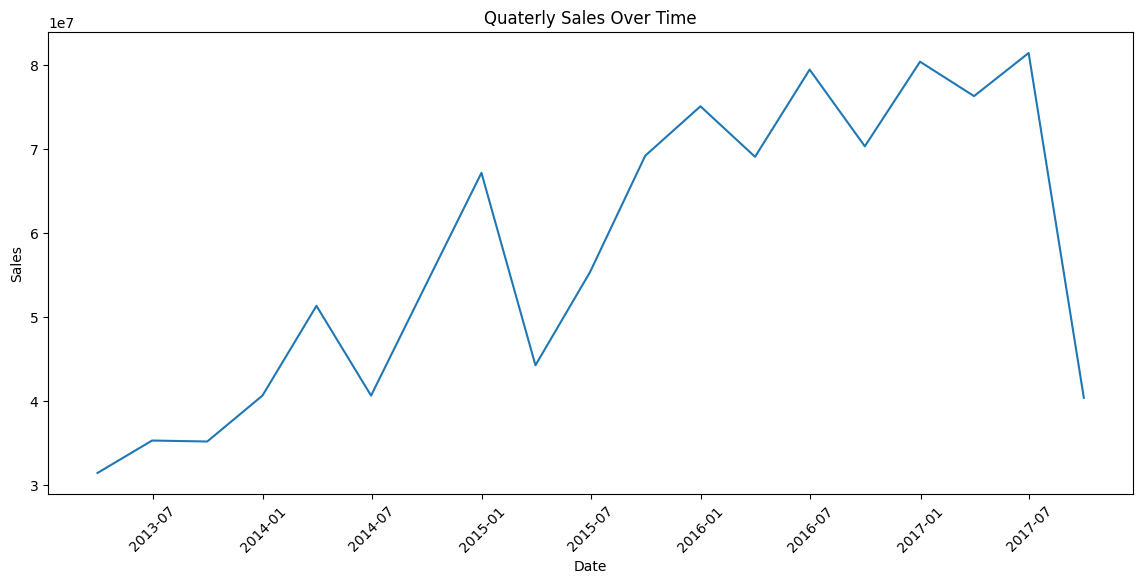

In [42]:
plt.figure(figsize=(14, 6))
plt.plot(quater_sales['total_daily_sales'])
plt.title('Quaterly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [43]:
decomposition = seasonal_decompose(monthly_sales['total_daily_sales'])

Text(0, 0.5, 'Residual')

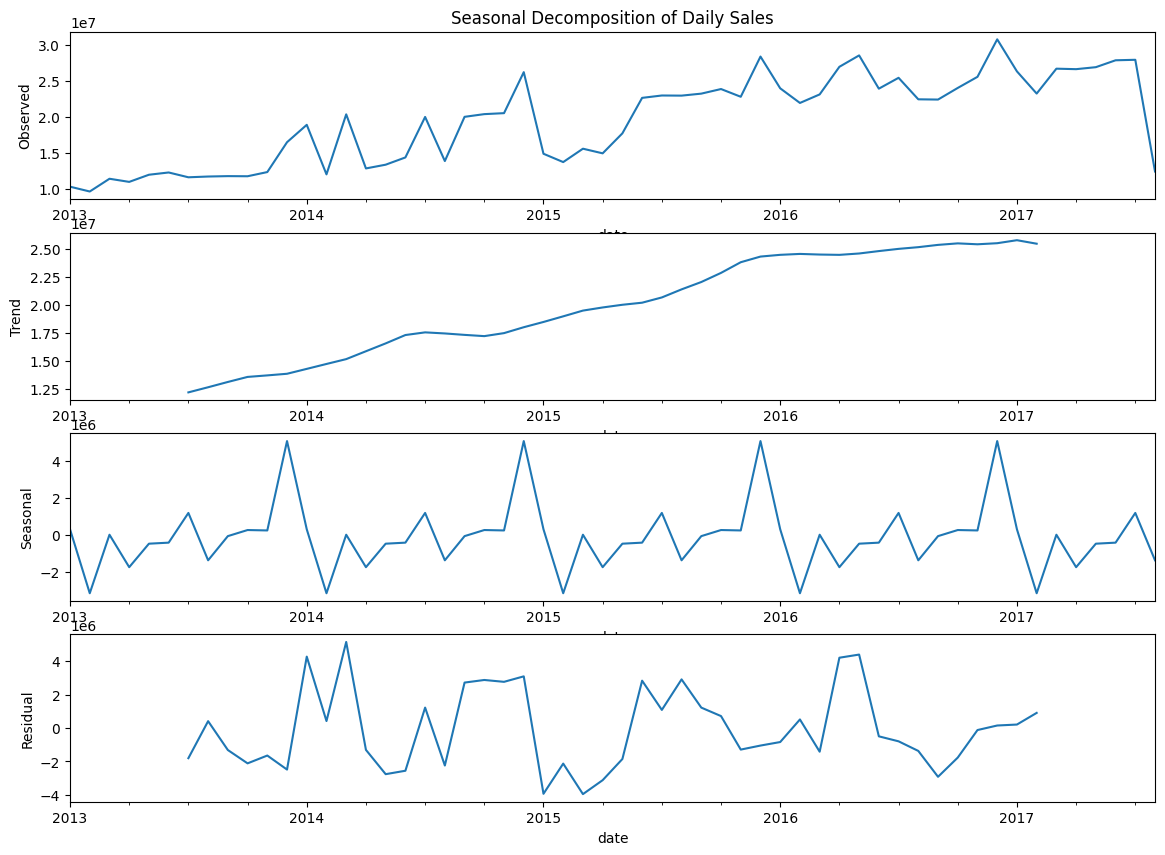

In [44]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition of Daily Sales')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

Based on the composition analysis, here are the take aways:
- Trend Analysis: There's a consistent upward trend in sales from 2013 to 2017, suggesting overall business growth and successful market expansion.
- Seasonal Fluctuations: Sales exhibit clear seasonal patterns with periodic peaks and valleys each year, indicating significant seasonal influences likely tied to holidays or major sales events.
- Residuals: The residuals, showing deviations from the modeled trend and seasonality, suggest additional unexplained factors are affecting sales. These may warrant further investigation to uncover underlying causes such as local events or market changes.

Let's plot the monthly sales alongside oil prices to better understand how sales growth correlates with broader economic trends.

In [45]:
daily_oil = sales_df.groupby('date')['daily_oil_price'].sum().reset_index()
monthly_oil = daily_oil.resample('M', on='date').sum()
monthly_oil.head()

,daily_oil_price
date,
2013-01-31,5231720.34
2013-02-28,4761646.56
2013-03-31,5150621.52
2013-04-30,4907877.48
2013-05-31,5400992.52


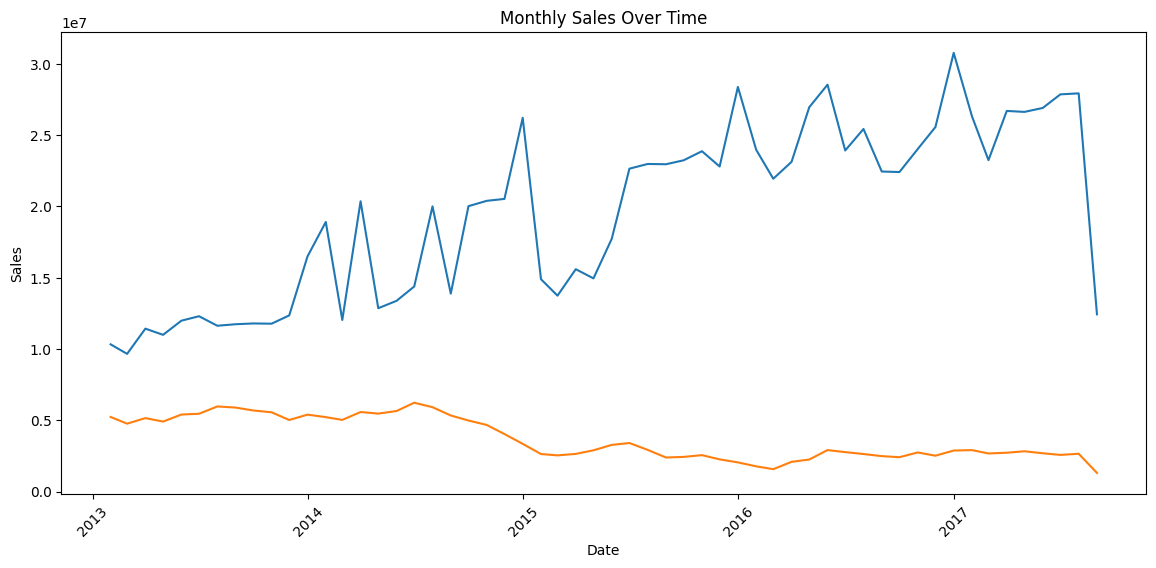

In [46]:
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['total_daily_sales'])
plt.plot(monthly_oil['daily_oil_price'])
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

#### Sales by day of week

In [47]:
daily_sales['day_of_week'] = daily_sales['date'].dt.dayofweek
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales.head()

,date,total_daily_sales,day_of_week,month
0,2013-01-01,2511.618999,1,1
1,2013-01-02,496092.417944,2,1
2,2013-01-03,361461.231124,3,1
3,2013-01-04,354459.677093,4,1
4,2013-01-05,477350.121229,5,1


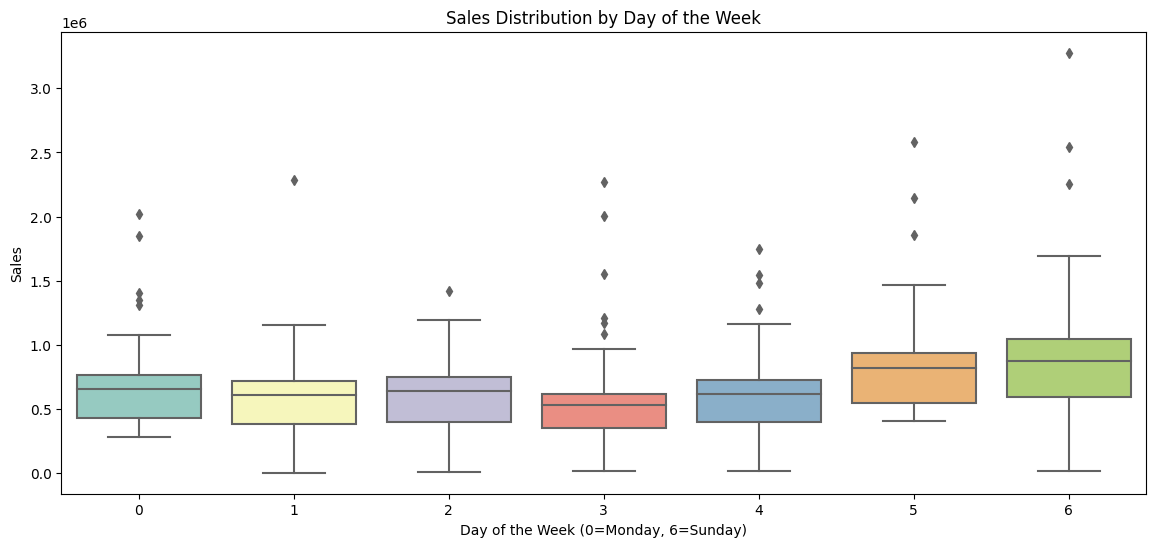

In [48]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=daily_sales, x='day_of_week', y='total_daily_sales', palette='Set3')
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Sales')
plt.show()

In [49]:
# Perform ANOVA test
model = ols('total_daily_sales ~ C(day_of_week)', data=daily_sales).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                      sum_sq      df         F        PR(>F)
C(day_of_week)  2.149474e+13     6.0  56.08255  2.553404e-63
Residual        1.071239e+14  1677.0       NaN           NaN


Given the low P value, we can reject the null hypothesis and conclude that at least one day has a significantly different average sales value.

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
     0      1  -48398.4752 0.3505 -116293.4355   19496.485  False
     0      2  -26317.6834 0.9151  -94353.6521  41718.2854  False
     0      3 -102122.2403 0.0002 -170158.2091 -34086.2715   True
     0      4  -36049.6165 0.7054 -104085.5853  31986.3523  False
     0      5  162083.2231    0.0   94118.0145 230048.4316   True
     0      6  230215.5743    0.0  162179.6055 298251.5431   True
     1      2   22080.7919 0.9625  -45885.0018  90046.5855  False
     1      3  -53723.7651 0.2286 -121689.5587  14242.0285  False
     1      4   12348.8588 0.9983  -55616.9349  80314.6524  False
     1      5  210481.6983    0.0   142586.738 278376.6585   True
     1      6  278614.0495    0.0  210648.2559 346579.8431   True
     2      3  -75804.5569 0.0179 -143911.2125  -7697.9014   True
     2    

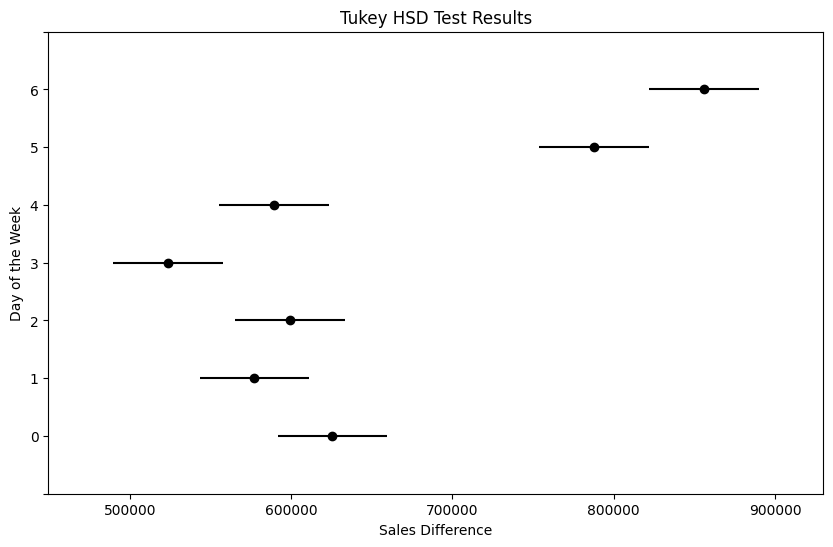

In [50]:
# Tukey's HSD post-hoc test
tukey = pairwise_tukeyhsd(endog=daily_sales['total_daily_sales'], groups=daily_sales['day_of_week'], alpha=0.05)
print(tukey)

# Plotting the results
tukey.plot_simultaneous(ylabel='Day of the Week', xlabel='Sales Difference')
plt.title('Tukey HSD Test Results')
plt.show()

Seems like Thursday tend to have low sales compared to weekdays, and Weekends (Saturday and Sunday) generally have significantly higher sales compared to weekdays.

#### Sales by month

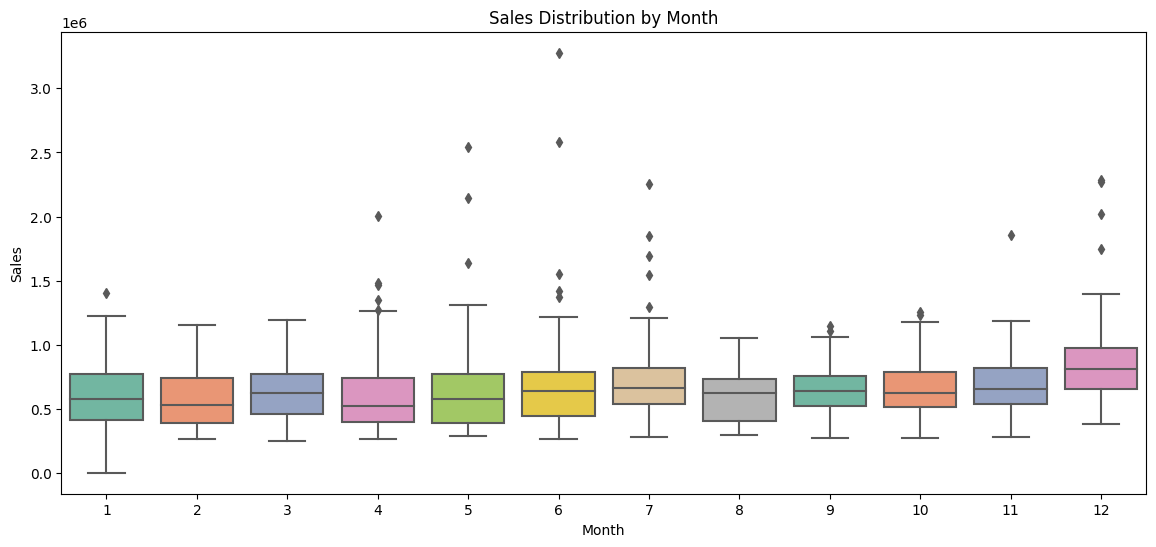

In [51]:
# Visualize Sales by Month
plt.figure(figsize=(14, 6))
sns.boxplot(data=daily_sales, x='month', y='total_daily_sales', palette='Set2')
plt.title('Sales Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

In [52]:
model = ols('total_daily_sales ~ C(month)', data=daily_sales).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq      df         F        PR(>F)
C(month)  7.011711e+12    11.0  8.764142  2.757031e-15
Residual  1.216069e+14  1672.0       NaN           NaN


Given the low P value, we can reject the null hypothesis and conclude that at least one month has a significantly different average sales value.

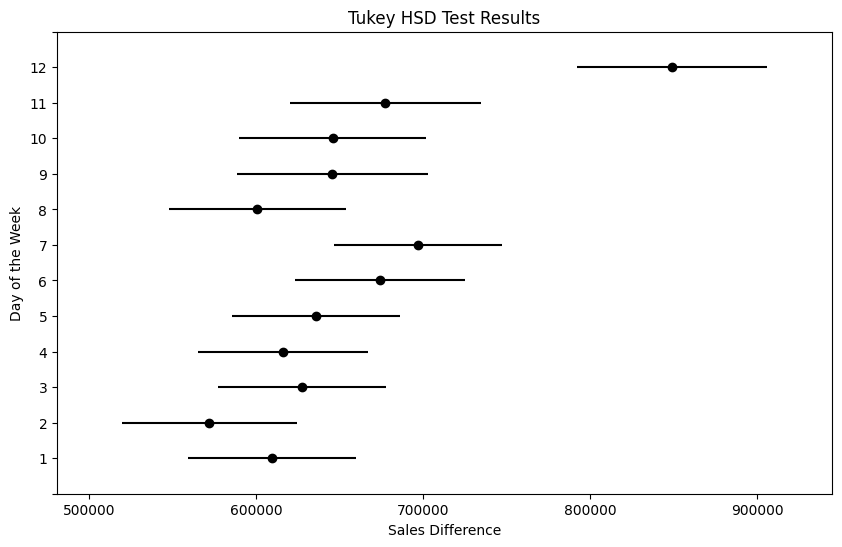

In [53]:
tukey = pairwise_tukeyhsd(endog=daily_sales['total_daily_sales'], groups=daily_sales['month'], alpha=0.05)

# Plotting the results
tukey.plot_simultaneous(ylabel='Day of the Week', xlabel='Sales Difference')
plt.title('Tukey HSD Test Results')
plt.show()

Seems like December generally have significantly higher sales compared to other months.

### Sales distributions by categorical features

In [54]:
sales_df.head()

,id,date,store_nbr,family,sales,onpromotion,daily_oil_price,holiday_type,holiday_locale,locale_name,...,store_type,store_cluster,day_of_week,month,quarter,date_month,total_daily_sales,total_daily_sales_by_store_nbr,contribution_ratio_by_date,contribution_ratio_by_date_store_nbr
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,...,D,13,1,1,1,2013-01-01,2511.618999,0.0,0.0,0.0


#### By stores

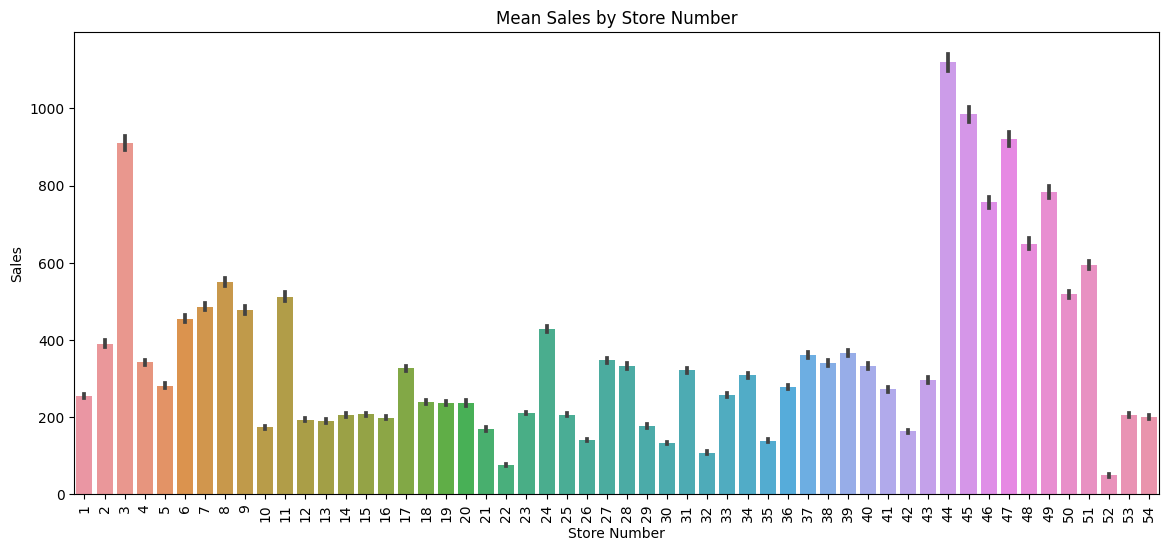

In [55]:
# Sales by store number
plt.figure(figsize=(14, 6))
sns.barplot(x='store_nbr', y='sales', data=sales_df)
plt.title('Mean Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

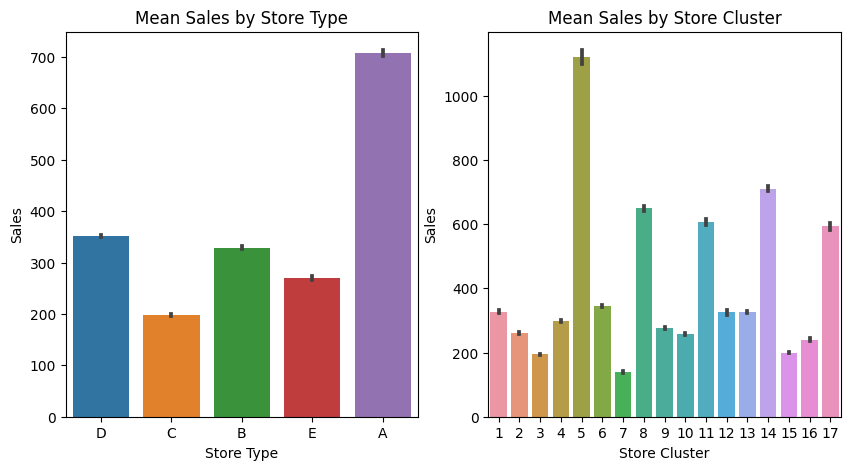

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [56]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))

plt.figure(figsize=(14, 6))
sns.barplot(x='store_type', y='sales', data=sales_df, ax=axes[0])
axes[0].set_title('Mean Sales by Store Type')
axes[0].set_xlabel('Store Type')
axes[0].set_ylabel('Sales')

plt.figure(figsize=(14, 6))
sns.barplot(x='store_cluster', y='sales', data=sales_df, ax=axes[1])
axes[1].set_title('Mean Sales by Store Cluster')
axes[1].set_xlabel('Store Cluster')
axes[1].set_ylabel('Sales')
plt.show()

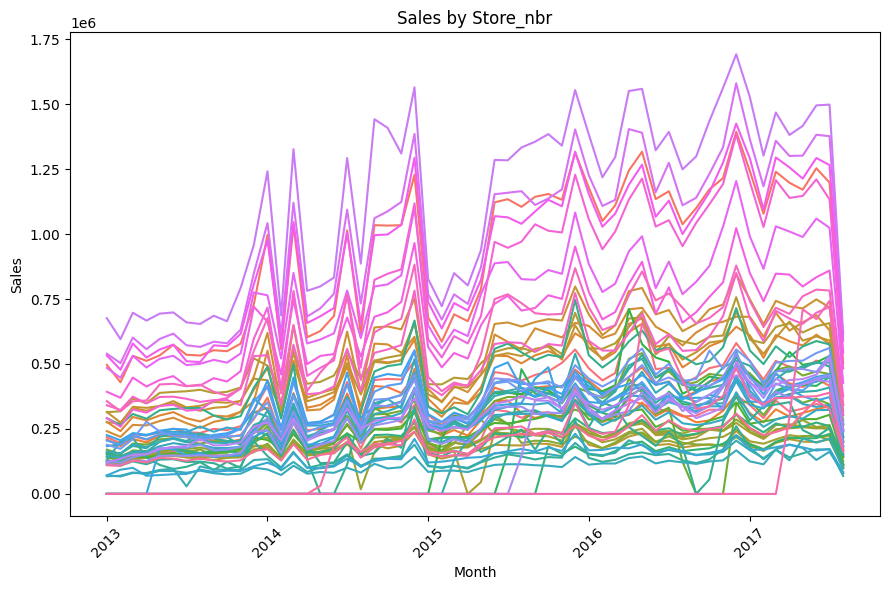

In [57]:
time_series_plot_by_category('store_nbr', False)

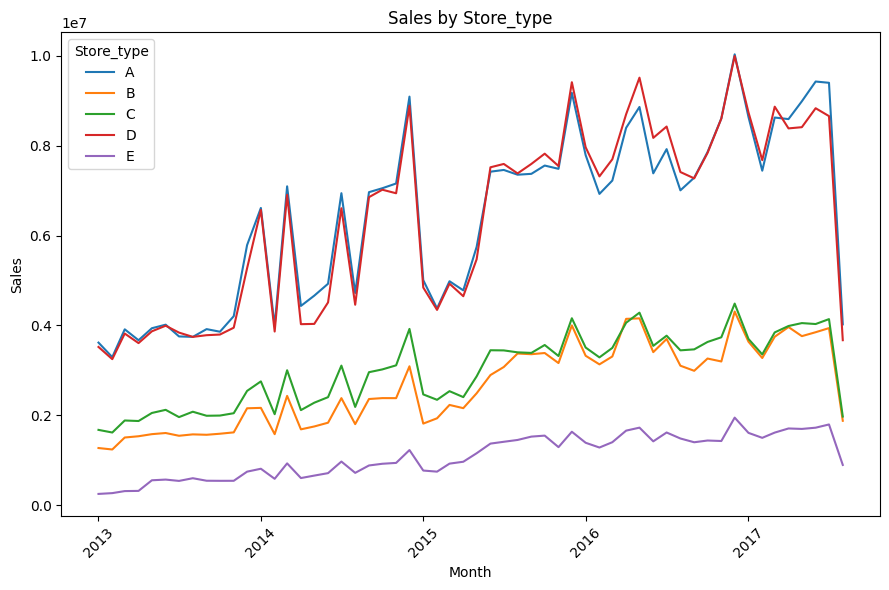

In [58]:
time_series_plot_by_category('store_type')

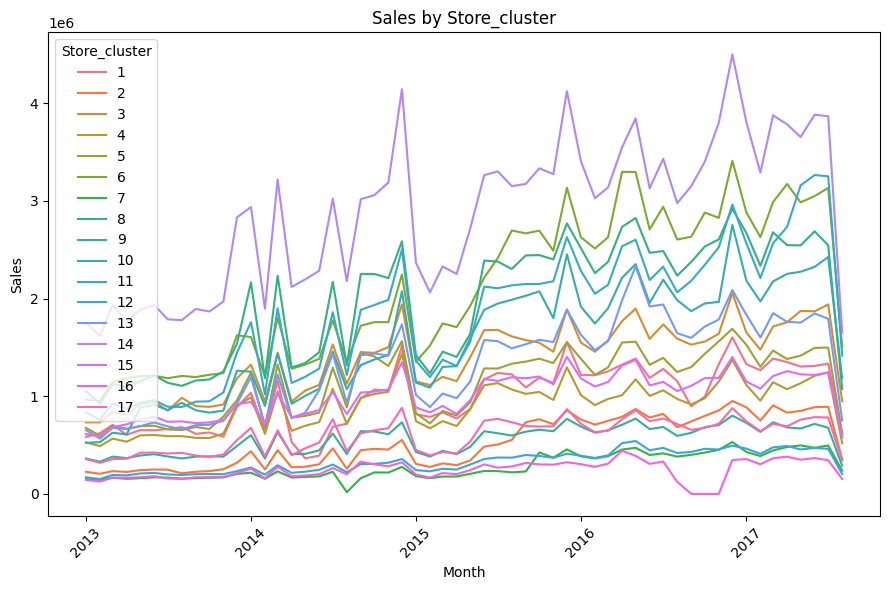

In [359]:
time_series_plot_by_category('store_cluster')

**Insights:** 
There is a significant variation in sales performance across different store types and clusters. Additionally, the sales trajectories show distinct differences, with certain clusters and types consistently outperforming others. Moreover, all charts reveal distinct seasonal trends, with sales peaking at similar times each year, indicating the influence of seasonal shopping behaviors on sales performance.


#### By product family

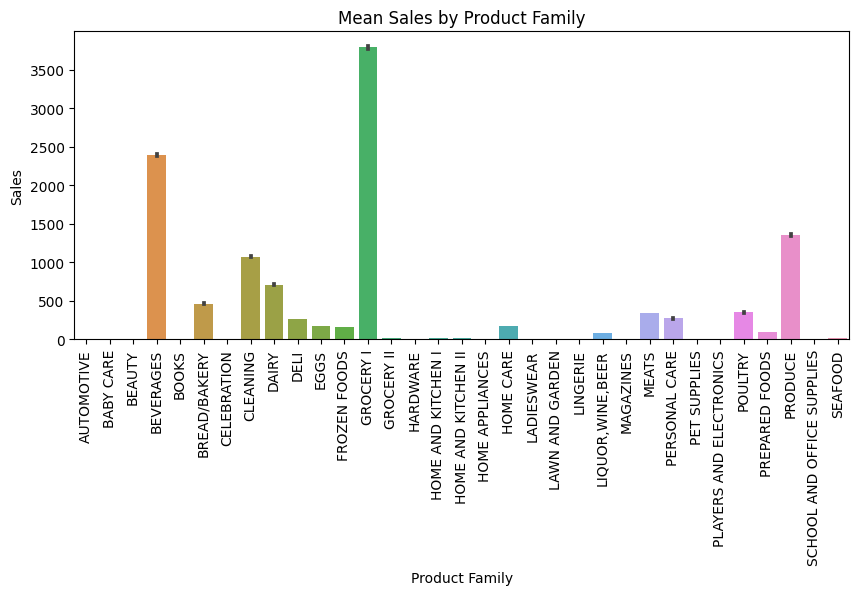

In [360]:
# Sales by product family
plt.figure(figsize=(10, 4))
sns.barplot(x='family', y='sales', data=sales_df)
plt.title('Mean Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

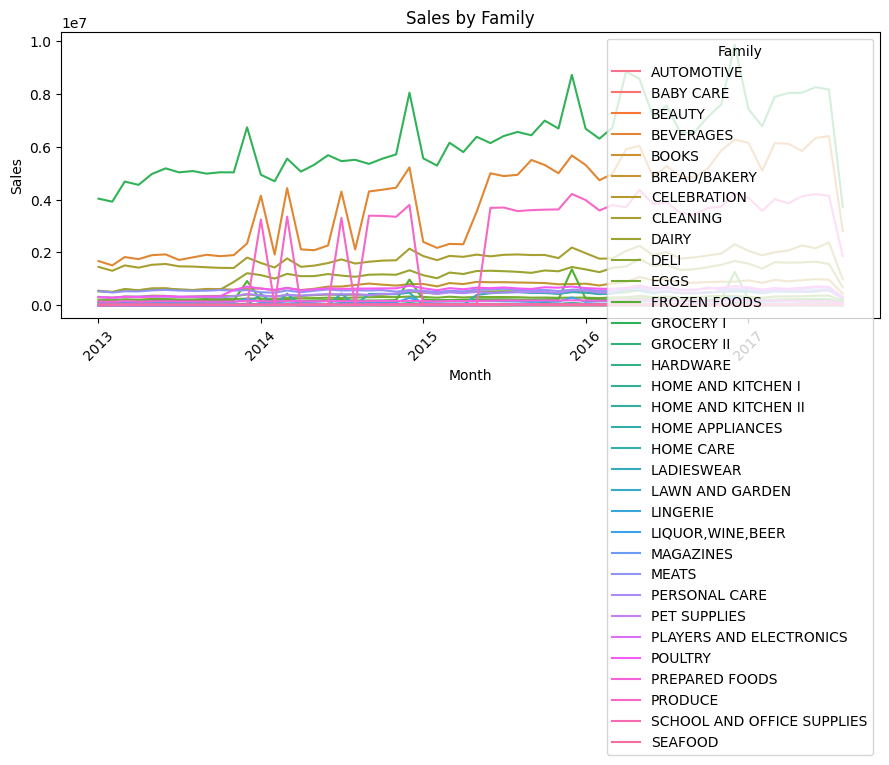

In [361]:
time_series_plot_by_category('family')

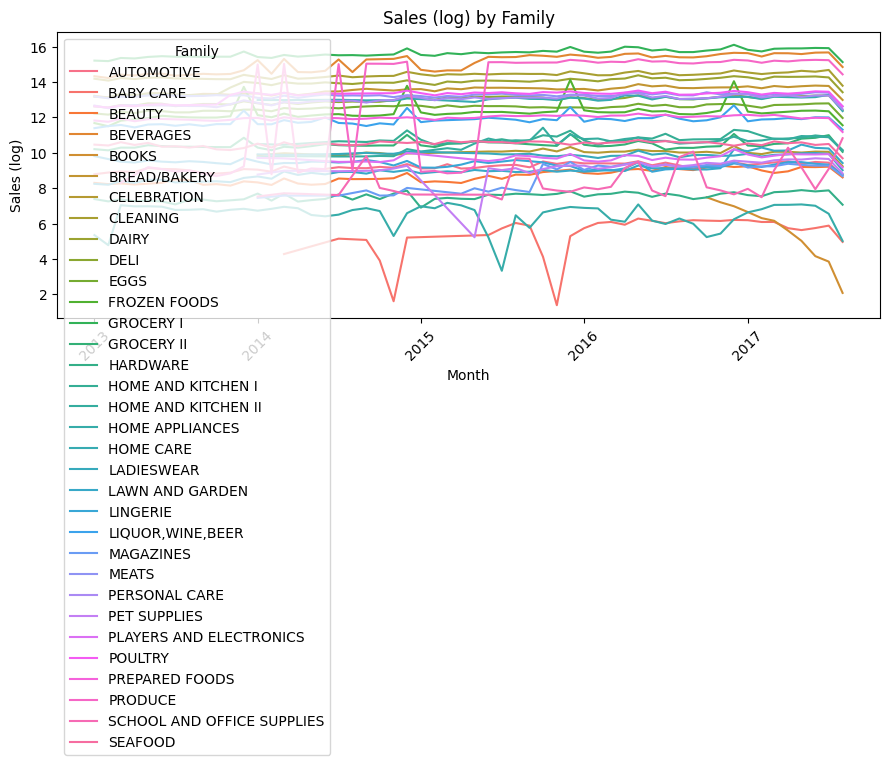

In [362]:
time_series_plot_by_category('family', True, True)

**Insights:** There is a significant variation in sales performance across different familys. Some shows strong seasonal trends while others don't.

#### By holiday

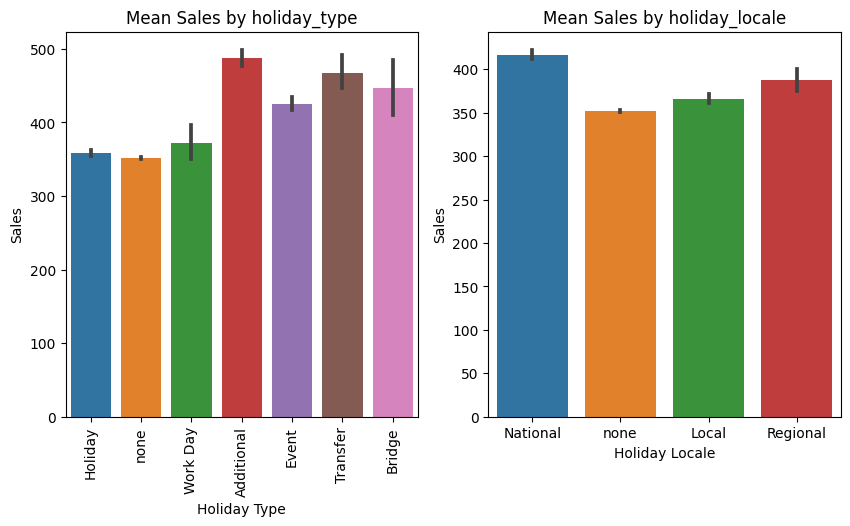

In [363]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))

sns.barplot(x='holiday_type', y='sales', data=sales_df, ax=axes[0])
axes[0].set_title('Mean Sales by holiday_type')
axes[0].set_xlabel('Holiday Type')
axes[0].set_ylabel('Sales')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.barplot(x='holiday_locale', y='sales', data=sales_df, ax=axes[1])
axes[1].set_title('Mean Sales by holiday_locale')
axes[1].set_xlabel('Holiday Locale')
axes[1].set_ylabel('Sales')
plt.show()

In [364]:
model = ols('sales ~ C(holiday_type)', data=sales_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                       sum_sq         df         F  PR(>F)
C(holiday_type)  1.915727e+09        6.0  260.5459     0.0
Residual         3.742964e+12  3054341.0       NaN     NaN


In [365]:
model = ols('sales ~ C(holiday_locale)', data=sales_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                         sum_sq         df           F         PR(>F)
C(holiday_locale)  1.028944e+09        3.0  279.814237  1.278698e-181
Residual           3.743851e+12  3054344.0         NaN            NaN


Based on anova test, holiday type and locale has significant impact for sales.

#### By location

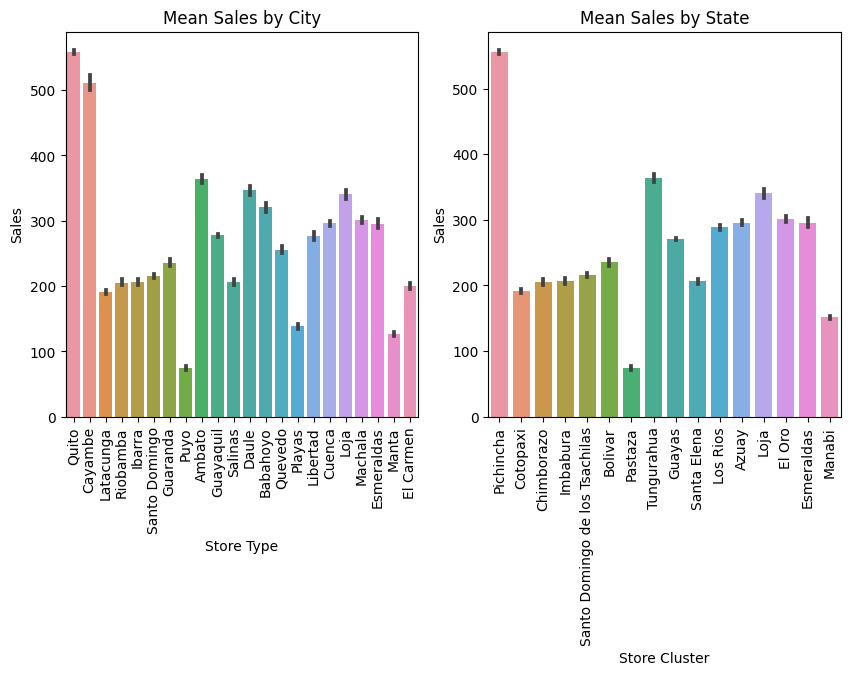

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [366]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))

plt.figure(figsize=(14, 6))
sns.barplot(x='city', y='sales', data=sales_df, ax=axes[0])
axes[0].set_title('Mean Sales by City')
axes[0].set_xlabel('Store Type')
axes[0].set_ylabel('Sales')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='sales', data=sales_df, ax=axes[1])
axes[1].set_title('Mean Sales by State')
axes[1].set_xlabel('Store Cluster')
axes[1].set_ylabel('Sales')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.show()

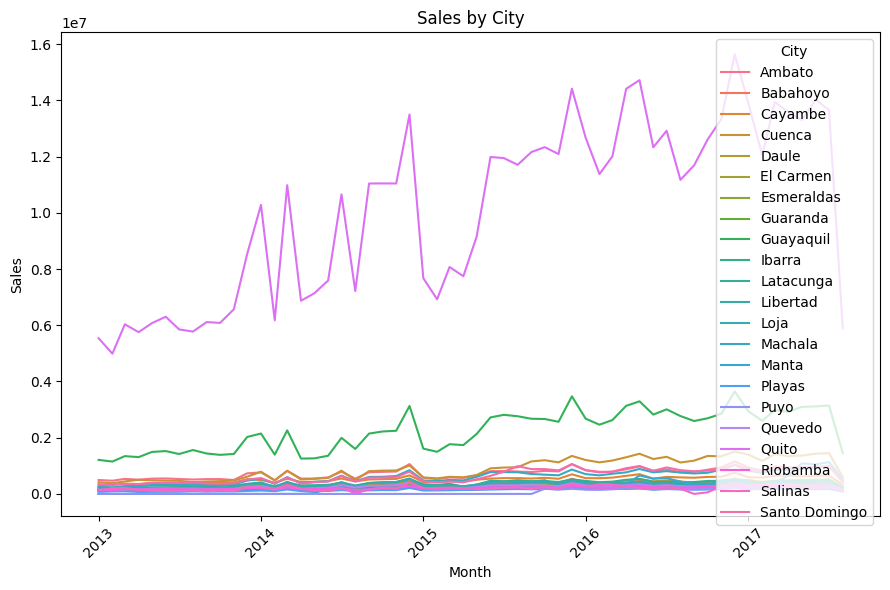

In [367]:
time_series_plot_by_category('city')

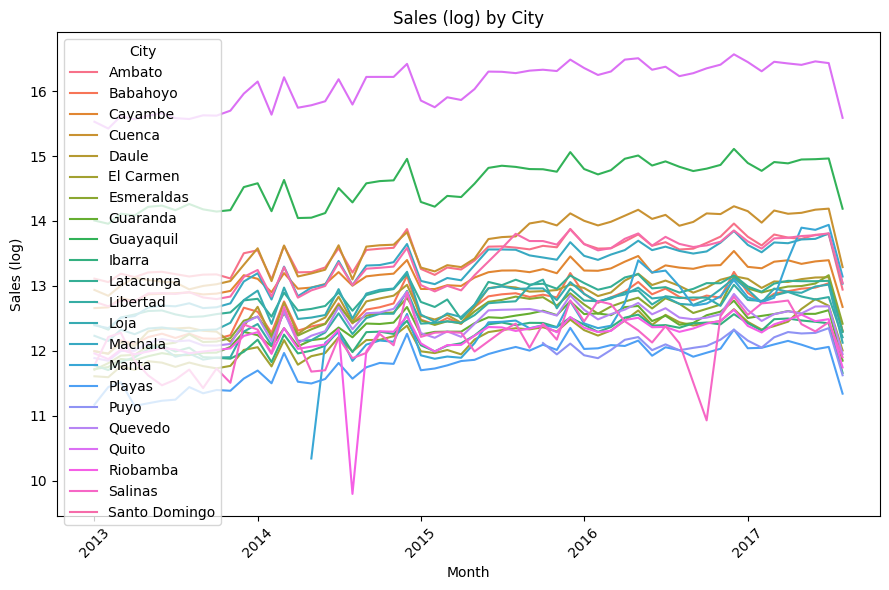

In [368]:
time_series_plot_by_category('city', True, True)

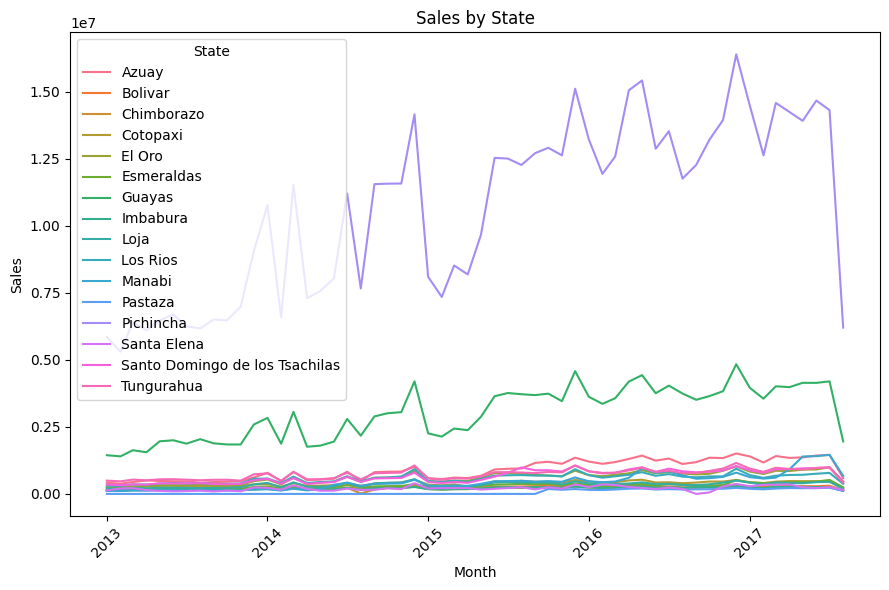

In [369]:
time_series_plot_by_category('state')

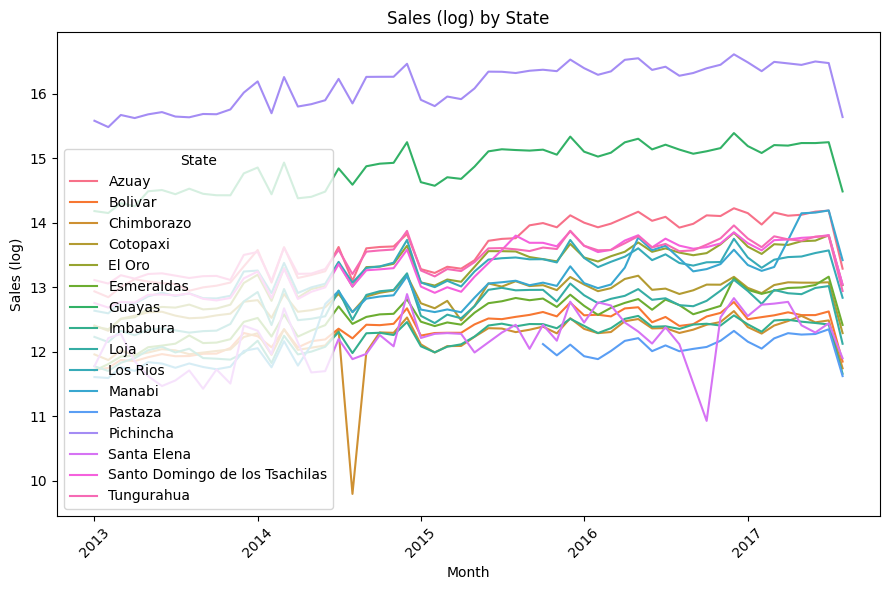

In [370]:
time_series_plot_by_category('state', True, True)

**Insights:** There is significant variation in sales performance across different cities and states. However, the overall sales trajectories are similar, with all locations exhibiting consistent seasonal trends.

# Sales correlation with numerical features

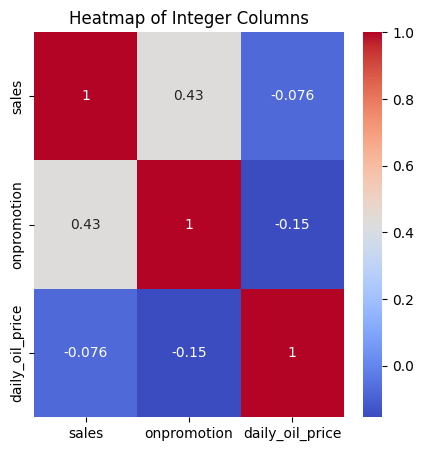

In [374]:
columns = ['sales', 'onpromotion', 'daily_oil_price']
num_columns = sales_df[columns]
plt.figure(figsize=(5, 5))
sns.heatmap(num_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Integer Columns')
plt.show()

In [375]:
monthly_sales_columns = sales_df.groupby('date_month')[columns].sum()

In [376]:
for cols in num_columns:
    print(f"{cols}: {pearsonr(monthly_sales_columns[cols], monthly_sales_columns.sales)}")

sales: PearsonRResult(statistic=0.9999999999999994, pvalue=0.0)
onpromotion: PearsonRResult(statistic=0.8195239449781535, pvalue=1.1445752970429303e-14)
daily_oil_price: PearsonRResult(statistic=-0.6773898836426184, pvalue=9.853586522219083e-09)


**Insights:** Sales show a strong positive correlation with promotions. Additionally, there is a moderate positive correlation with the number of transactions and a moderate negative correlation with daily oil prices.

### Time Series Feature Analysis

In [378]:
result = adfuller(daily_sales['total_daily_sales'])
print("The p-value for the ADF test is ", result[1])

The p-value for the ADF test is  0.04178984005432121


Based on the Augmented Dickey-Fuller test result, we can conclude that daily sales data is **stationary**.

In [379]:
daily_sales = daily_sales.set_index('date')
chg_sales = daily_sales.diff()
chg_sales = chg_sales.dropna()
chg_sales.head()

,total_daily_sales,day_of_week,month
date,,,
2013-01-02,493580.798945,1.0,0.0
2013-01-03,-134631.186820,1.0,0.0
2013-01-04,-7001.554031,1.0,0.0
2013-01-05,122890.444136,1.0,0.0
2013-01-06,42345.279859,1.0,0.0


In [381]:
daily_sales['rolling_mean_30'] = daily_sales['total_daily_sales'].rolling(window=30).mean()
daily_sales

,total_daily_sales,day_of_week,month,rolling_mean_30
date,,,,
2013-01-01,2511.618999,1,1,NaN
2013-01-02,496092.417944,2,1,NaN
2013-01-03,361461.231124,3,1,NaN
2013-01-04,354459.677093,4,1,NaN
2013-01-05,477350.121229,5,1,NaN
...,...,...,...,...
2017-08-11,826373.722022,4,8,842283.135083
2017-08-12,792630.535079,5,8,847715.774155
2017-08-13,865639.677471,6,8,851054.109491


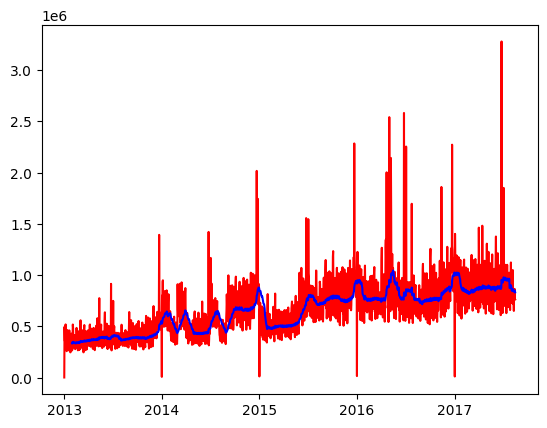

In [383]:
plt.plot(daily_sales.total_daily_sales, color="red")
plt.plot(daily_sales.rolling_mean_30, color="blue",label="Original Passenger Data")
plt.show()

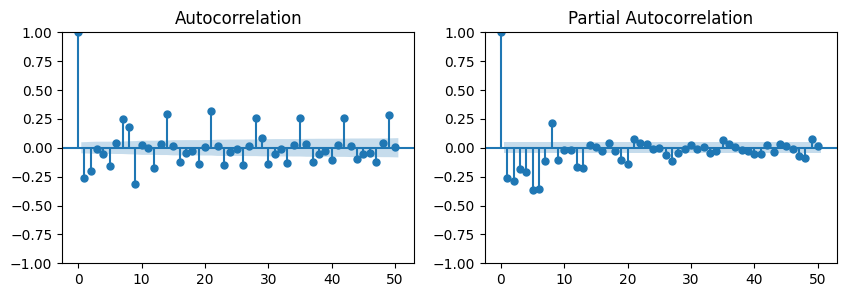

In [387]:
fig, axes = plt.subplots(1,2, figsize=(10, 3))

# Plot the ACF
plot_acf(chg_sales['total_daily_sales'], lags=50, ax=axes[0])
# Plot the PACF
plot_pacf(chg_sales['total_daily_sales'], lags=50, ax=axes[1])
plt.show()

In [393]:
daily_sales['Lag_1'] = daily_sales['total_daily_sales'].shift(1)
daily_sales['Lag_7'] = daily_sales['total_daily_sales'].shift(7)

daily_sales = daily_sales.reindex(columns=['total_daily_sales', 'Lag_1', 'Lag_7'])

daily_sales.head()

,total_daily_sales,Lag_1,Lag_7
date,,,
2013-01-01,2511.618999,NaN,NaN
2013-01-02,496092.417944,2511.618999,NaN
2013-01-03,361461.231124,496092.417944,NaN
2013-01-04,354459.677093,361461.231124,NaN
2013-01-05,477350.121229,354459.677093,NaN


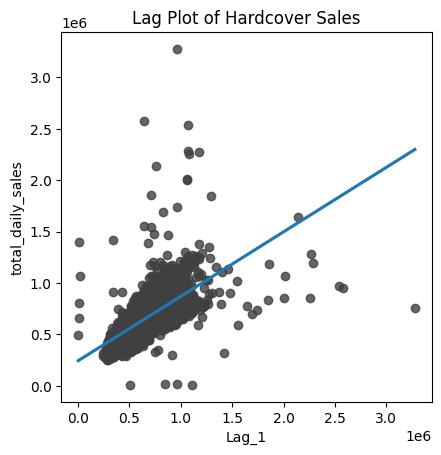

In [392]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='total_daily_sales', data=daily_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

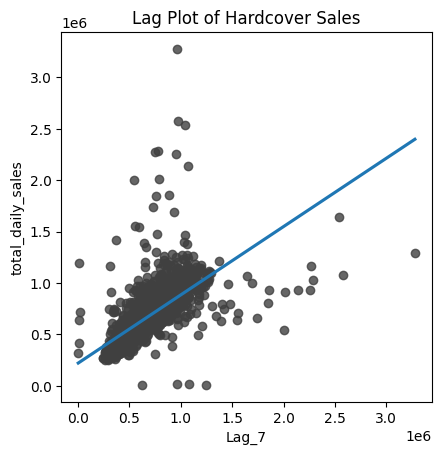

In [395]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_7', y='total_daily_sales', data=daily_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

In [397]:
pearsonr(daily_sales['total_daily_sales'].fillna(0), daily_sales['Lag_7'].fillna(0))

PearsonRResult(statistic=0.6669609228791673, pvalue=3.3287170237214356e-217)